In [1]:
###======= Imports =======###
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from alpha_vantage.timeseries import TimeSeries 
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from transformers import AutoTokenizer, RwkvConfig, RwkvModel, RwkvPreTrainedModel
from rwkv.model import RWKV
import math


c:\Users\Tomer\anaconda3\envs\deep_proj\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number data points 5936 from 1999-11-01 to 2023-06-05


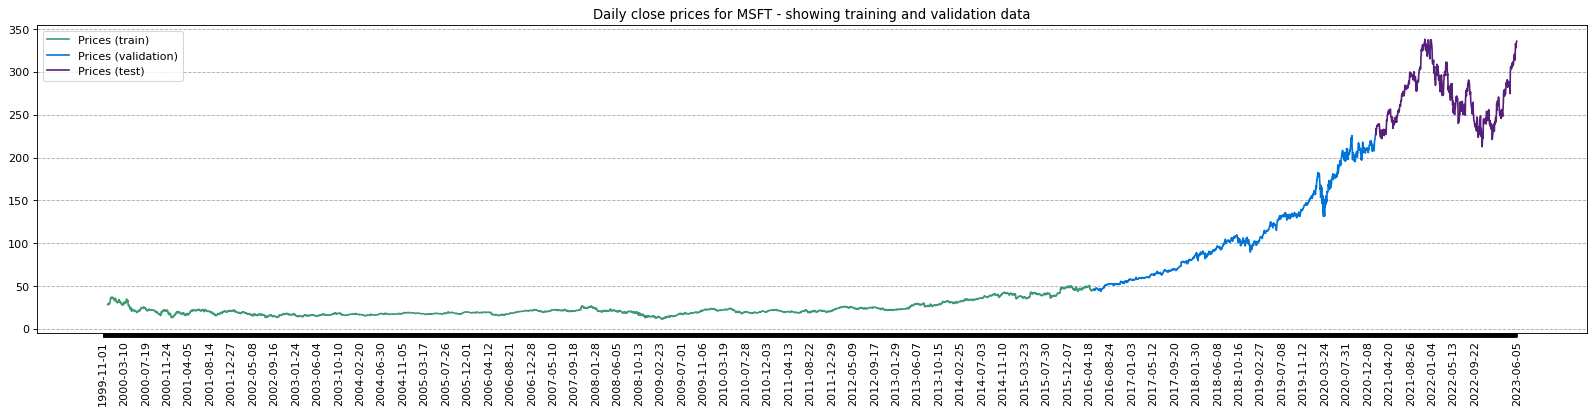

Train data shape (4141, 20, 1) (4141,)
Validation data shape (1183, 20, 1) (1183,)
Test data shape (592, 20, 1) (592,)


In [2]:
import Utils
# Get dataloaders from our Utils file
train_loader, val_loader, test_loader = Utils.run()

In [3]:
# Define Transformer Model
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5, norm_first=False):
        super(TransformerModel, self).__init__()
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout, norm_first=norm_first)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

In [7]:
# instantiate Transformer model
transformer_model = TransformerModel(ntoken=int(20e3), ninp=220, nhead=2, nhid=220, nlayers=4, dropout=0.2, norm_first=True)

In [45]:
# Define RWKV model
rwkv_config = RwkvConfig(vocab_size=0, context_length=256, hidden_size=0, num_hidden_layers=8)
rwkv_model = RwkvModel(rwkv_config)

c:\Users\Latzres\Anaconda3\envs\deep_proj\lib\site-packages\torch\nn\init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [46]:
epochs = 20
criterion = nn.MSELoss()
optimizer = torch.optim.RAdam(transformer_model.parameters(), lr=2.5e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
model = rwkv_model
model.to(device)

RwkvModel(
  (embeddings): Embedding(0, 0)
  (blocks): ModuleList(
    (0): RwkvBlock(
      (pre_ln): LayerNorm((0,), eps=1e-05, elementwise_affine=True)
      (ln1): LayerNorm((0,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((0,), eps=1e-05, elementwise_affine=True)
      (attention): RwkvSelfAttention(
        (time_shift): ZeroPad2d((0, 0, 1, -1))
        (key): Linear(in_features=0, out_features=0, bias=False)
        (value): Linear(in_features=0, out_features=0, bias=False)
        (receptance): Linear(in_features=0, out_features=0, bias=False)
        (output): Linear(in_features=0, out_features=0, bias=False)
      )
      (feed_forward): RwkvFeedForward(
        (time_shift): ZeroPad2d((0, 0, 1, -1))
        (key): Linear(in_features=0, out_features=0, bias=False)
        (receptance): Linear(in_features=0, out_features=0, bias=False)
        (value): Linear(in_features=0, out_features=0, bias=False)
      )
    )
    (1-7): 7 x RwkvBlock(
      (ln1): LayerNo

In [48]:
def evaluate(data_loader):
    data_iterator = iter(data_loader)
    nb_batches = len(data_loader)
    model.eval()
    acc = 0 
    for batch in data_iterator:
        x = batch.text.to(device)
        y = batch.label.to(device)
                
        out = model(x)
        acc += (out.argmax(1) == y).cpu().numpy().mean()

    print(f"eval accuracy: {acc / nb_batches}")
    

def train(train_loader, valid_loader):
    
    for epoch in range(epochs):
        train_iterator, valid_iterator = iter(train_loader), iter(valid_loader)
        nb_batches_train = len(train_loader)
        train_acc = 0
        model.train()
        losses = 0.0

        for idx, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            print(x.shape)
            print(x)
            out = model(x)

            loss = criterion(out.contigous(), y.contigous())
            
            optimizer.zero_grad()

            loss.backward()
            losses += loss.item()

            optimizer.step()
                        
            train_acc += (out.argmax(1) == y).cpu().numpy().mean()
        
        print(f"epoch {epoch}: train loss: {losses / nb_batches_train}")
        print(f"training accuracy: {train_acc / nb_batches_train}")
        print('evaluating on validation:')
        evaluate(valid_loader)

In [50]:
train(train_loader, val_loader)

torch.Size([64, 20, 1])
tensor([[[-0.6182],
         [-0.5970],
         [-0.6080],
         ...,
         [-0.6127],
         [-0.6184],
         [-0.6163]],

        [[-0.5526],
         [-0.5546],
         [-0.5529],
         ...,
         [-0.5398],
         [-0.5442],
         [-0.5437]],

        [[-0.6066],
         [-0.5989],
         [-0.5994],
         ...,
         [-0.5938],
         [-0.5934],
         [-0.5916]],

        ...,

        [[-0.5418],
         [-0.5393],
         [-0.5382],
         ...,
         [-0.5381],
         [-0.5371],
         [-0.5336]],

        [[-0.4426],
         [-0.4474],
         [-0.4457],
         ...,
         [-0.4414],
         [-0.4414],
         [-0.4260]],

        [[-0.5531],
         [-0.5551],
         [-0.5531],
         ...,
         [-0.5632],
         [-0.5683],
         [-0.5747]]])


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)